## Análisis de calidad sobre números telefónicos almacenados

**Updated**: 26-abr-2023 <br>
**Created**: 14-abr-2023

### Environment settings

In [1]:
# import libraries
import numpy as np
import pandas as pd
import polars as pl
import pyarrow

In [3]:
# read csv file containing sql query
df = pl.read_csv('telefonos_query.csv', ignore_errors=True)

In [4]:
# rename columns by lower case strings
df = (
    df.select(
        pl.all().map_alias(lambda col_name: col_name.lower())
    )
)

### Arrange all phone columns into one columnm

In [5]:
# select all columns less these
tel1 = df.select(pl.exclude(['telefono_prop','telefono_referencia',
                                'telefono_ticket','telefono_3',
                                'telefono_4',
                                ]))
# create a column with a fixed value
tel1 = tel1.with_columns(pl.lit('telefono').alias('tipo_telefono'))

In [6]:
# select all columns less these
tel2 = df.select(pl.exclude(['telefono','telefono_referencia',
                                'telefono_ticket','telefono_3','telefono_4',
                                ]))
# rename columns
tel2 = tel2.rename({'telefono_prop':'telefono'})
# create a column with a fixed value
tel2 = tel2.with_columns(pl.lit('telefono_prop').alias('tipo_telefono'))

In [7]:
# select all columns less these
tel3 = df.select(pl.exclude(['telefono','telefono_prop','telefono_ticket',
                                'telefono_3','telefono_4'
                                ]))
# rename columns
tel3 = tel3.rename({'telefono_referencia':'telefono'})
# create a column with a fixed value
tel3 = tel3.with_columns(pl.lit('telefono_referencia').alias('tipo_telefono'))

In [8]:
# select all columns less these
tel4 = df.select(pl.exclude(['telefono','telefono_prop','telefono_referencia',
                                'telefono_3','telefono_4',
                                ]))
# rename columns
tel4 = tel4.rename({'telefono_ticket':'telefono'})
# create a column with a fixed value
tel4 = tel4.with_columns(pl.lit('telefono_ticket').alias('tipo_telefono'))

In [9]:
# select all columns less these
tel5 = df.select(pl.exclude(['telefono','telefono_prop','telefono_referencia',
                                'telefono_ticket','telefono_4',
                                ]))
# rename columns
tel5 = tel5.rename({'telefono_3':'telefono'})
# create a column with a fixed value
tel5 = tel5.with_columns(pl.lit('telefono_3').alias('tipo_telefono'))

In [10]:
# select all columns less these
tel6 = df.select(pl.exclude(['telefono','telefono_prop','telefono_referencia',
                                'telefono_ticket','telefono_3',
                                ]))
# rename columns
tel6 = tel6.rename({'telefono_4':'telefono'})
# create a column with a fixed value
tel6 = tel6.with_columns(pl.lit('telefono_4').alias('tipo_telefono'))

In [11]:
# union tables
tels = pl.concat([tel1, tel2, tel3, tel4, tel5, tel6,])

### Sin teléfonos

In [12]:
null_tels = (
    tels.filter(
       (pl.col('telefono')=='(null)')
    )
)

### Teléfonos con letras

In [13]:
# phones with letters
phone_letters = tels.filter(
    (pl.col("telefono").str.contains(r"[a-zA-Z]$"))
)

### Teléfonos numéricos

In [14]:
# convert phone columns to numeric
tels = (
    tels.with_columns(pl.col('telefono').cast(pl.Int64, strict=False))
)

In [15]:
# create columns with phone columns length
tels = (
    tels.with_columns(
        (pl.col('telefono').cast('str').str.lengths().alias('longitud_telefono'))
    )
)

In [16]:
# case when phone column is int
nums = (
    tels.filter(~pl.col('telefono').is_null())
)

In [17]:
# case when phone column is string
#nums = tels.filter(pl.col('telefono').str.contains(r'\d$'))

### Teléfonos inválidos

In [18]:
invalidos = (
    nums.filter(
        (pl.col('longitud_telefono')>10)
        | (pl.col('longitud_telefono')<10)
    )
)

### Teléfonos válidos duplicados

In [19]:
validos = (
    nums.filter(
        (pl.col('longitud_telefono')==10)
    )
)

### Teléfonos válidos únicos

In [20]:
unicos = validos.unique(subset=['telefono'])

### Teléfonos válidos revisados

In [21]:
tels_ok =(
    validos.filter(
        (~pl.col("telefono").str.contains("^[0]"))
        & (~pl.col("telefono").str.contains("^[1]"))
        & (~pl.col("telefono").str.contains("^[2][0]{8,}"))
        & (~pl.col("telefono").str.contains("^[2][2]{8,}"))
        & (~pl.col("telefono").str.contains("^[3][0]{8,}"))
        & (~pl.col("telefono").str.contains("^[3][3]{8,}"))
        & (~pl.col("telefono").str.contains("^[4][0]{8,}"))
        & (~pl.col("telefono").str.contains("^[4][4]{8,}"))
        & (~pl.col("telefono").str.contains("^[5][0]{8,}"))
        & (~pl.col("telefono").str.contains("^[5][5]{8,}"))
        & (~pl.col("telefono").str.contains("^[6][0]{8,}"))
        & (~pl.col("telefono").str.contains("^[6][6]{8,}"))
        & (~pl.col("telefono").str.contains("^[7][0]{8,}"))
        & (~pl.col("telefono").str.contains("^[7][7]{8,}"))
        & (~pl.col("telefono").str.contains("^[8][0]{8,}"))
        & (~pl.col("telefono").str.contains("^[8][8]{8,}"))
        & (~pl.col("telefono").str.contains("^[9][0]{8,}"))
        & (~pl.col("telefono").str.contains("^[9][9]{8,}"))
    )
).sort('telefono')

In [22]:
rev_unicos = tels_ok.unique(subset=['telefono'])

### Clientes con teléfonos

In [23]:
# get unique and count
tels_ok.select(pl.col('clave_bodega||clave_cliente')).unique().select(pl.count())

count
u32
495476


In [24]:
# create combined column out of client and phone
tels_ok = (
    tels_ok.with_columns(
        (pl.col('clave_bodega||clave_cliente').cast('str')+"-"+(pl.col('telefono').cast('str')))
            .alias('combined'))
)

In [25]:
# get unique phones from combination client-phone
num_unicos = tels_ok.unique(subset='combined')

### Clientes con más de 01 teléfono compartido

In [26]:
# sum of count of clientes with shared phones
# create groupby and filter by count > 1 and sort by phone and sum of count
(
    num_unicos.groupby('telefono')
        .agg(pl.col('clave_bodega||clave_cliente').count())
        .filter(pl.col('clave_bodega||clave_cliente')>1)
        .sort('telefono')
).select(pl.sum('clave_bodega||clave_cliente'))

clave_bodega||clave_cliente
u32
53325


In [27]:
# example of clients sharing phones
num_unicos.filter(pl.col('telefono') == 2104482121).head()

clave_bodega||clave_cliente,clave_bodega,bodega,bodega||clave_cliente,clave_cliente,nom_cliente,canal,categoria,clave_ruta_desarrollo,clas_ruta_prev_progr,clave_ruta_ecommerce,con_venta,coordx,coordy,fecha_alta,fecha_baja,frecuencia_visita,frecuencia_visita_ecommerce,frecuencia_visita_desarrollo,giro,grupo_ruta_preventa,nom_propietario,potencial,region,status,subcanal,telefono,territorio,tipo_cedis,tipo_propietario,ultima_fecha_compra,estrategia_comercial,tipo_telefono,longitud_telefono,combined
i64,i64,str,str,i64,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str,i64,str,i64,str,str,i64,str,str,str,u32,str
4301420,430,"""GALEANA DA""","""GALEANA DA1420…",1420,"""MARIA DE JESUS…","""Tradicional""","""D""","""(null)""","""Foranea""","""(null)""","""CV""",0.0,0.0,"""[2012/02/07:12…","""(null)""","""M""","""(null)""","""(null)""","""04-Miscelaneas…","""1""","""MARIA DE JESUS…","""(null)""","""NORTE""",1,"""Tradicional""",2104482121,"""DISTRIBUIDORES…","""R""",2,"""(null)""","""NUEVO""","""telefono""",10,"""4301420-210448…"
4851353,485,"""LINARES DA""","""LINARES DA1353…",1353,"""PEDRO RETA PER…","""Tradicional""","""D""","""(null)""","""Foranea""","""(null)""","""CV""",0.0,0.0,"""[2011/09/23:12…","""(null)""","""J""","""(null)""","""(null)""","""04-Miscelaneas…","""1""","""PEDRO RETA FLO…","""(null)""","""NORTE""",1,"""Tradicional""",2104482121,"""DISTRIBUIDORES…","""R""",2,"""[2013/10/04:12…","""NUEVO""","""telefono""",10,"""4851353-210448…"
4301369,430,"""GALEANA DA""","""GALEANA DA1369…",1369,null,"""Tradicional""","""D""","""(null)""","""Foranea""","""(null)""","""CV""",0.0,0.0,"""[2011/10/08:12…","""(null)""","""V""","""(null)""","""(null)""","""04-Miscelaneas…","""1""","""MARIA DEL SOCO…","""(null)""","""NORTE""",1,"""Tradicional""",2104482121,"""DISTRIBUIDORES…","""R""",2,"""(null)""","""NUEVO""","""telefono""",10,"""4301369-210448…"
4851431,485,"""LINARES DA""","""LINARES DA1431…",1431,"""NALLELY MATA H…","""Tradicional""","""D""","""(null)""","""Foranea""","""(null)""","""CV""",0.0,0.0,"""[2012/03/26:12…","""(null)""","""WS""","""(null)""","""(null)""","""04-Miscelaneas…","""1""","""NALLELY MATA H…","""(null)""","""NORTE""",1,"""Tradicional""",2104482121,"""DISTRIBUIDORES…","""R""",2,"""[2013/10/07:12…","""NUEVO""","""telefono""",10,"""4851431-210448…"
4301378,430,"""GALEANA DA""","""GALEANA DA1378…",1378,"""ABIGAIL ORTA M…","""Tradicional""","""D""","""(null)""","""Foranea""","""(null)""","""CV""",0.0,0.0,"""[2011/10/21:12…","""(null)""","""J""","""(null)""","""(null)""","""04-Miscelaneas…","""1""","""ABIGAIL ORTA""","""(null)""","""NORTE""",1,"""Tradicional""",2104482121,"""DISTRIBUIDORES…","""R""",2,"""(null)""","""NUEVO""","""telefono""",10,"""4301378-210448…"


In [28]:
tel_clientes = tels_ok.groupby('telefono').agg(pl.count(),pl.col('clave_bodega||clave_cliente'))
clientes_tels = tels_ok.groupby('clave_bodega||clave_cliente').agg(pl.count(),pl.col('telefono'))

### Resultados

In [29]:
print(f'Total registros: {df.shape[0]:,.0f}')
print(f'Total telefonos: {tels.shape[0]:,.0f}')
print(f'Sin numero: {null_tels.shape[0]:,.0f}')
print(f'Tels texto: {phone_letters.shape[0]:,.0f}')
print(f'Num tels: {nums.shape[0]:,.0f}')
print(f'Tels invalidos: {invalidos.shape[0]:,.0f}')
print(f'Tels validos: {validos.shape[0]:,.0f}')
print(f'Tels revisados: {tels_ok.shape[0]:,.0f}')
print(f'Tels unicos: {unicos.shape[0]:,.0f}')
print(f'Tels unicos rev: {rev_unicos.shape[0]:,.0f}')

Total registros: 1,082,580
Total telefonos: 6,495,480
Sin numero: 5,397,938
Tels texto: 7,706
Num tels: 1,082,550
Tels invalidos: 80,532
Tels validos: 1,002,018
Tels revisados: 999,038
Tels unicos: 625,663
Tels unicos rev: 624,639


In [33]:
data = {
    'Concepto': ['Total registros', 'Total telefonos', 'Sin numero', 'Tels texto', 'Num tels', 'Tels invalidos', 'Tels validos', 'Tels revisados', 'Tels unicos', 'Tels unicos rev'],
    'Cantidad': [df.shape[0], tels.shape[0], null_tels.shape[0], phone_letters.shape[0], nums.shape[0], invalidos.shape[0], validos.shape[0], tels_ok.shape[0], unicos.shape[0], rev_unicos.shape[0]]
}

In [36]:
data = pd.DataFrame(data)

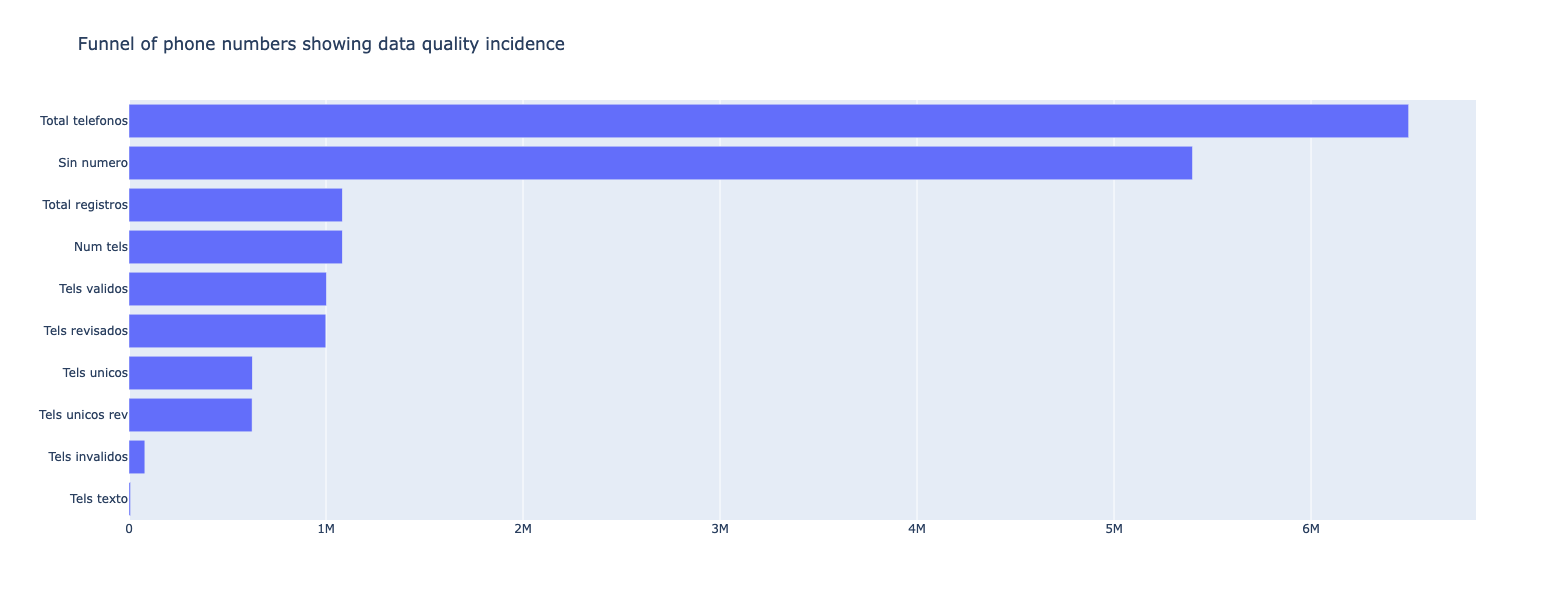

In [44]:
import plotly.express as px
fig = px.bar(data.sort_values(by='Cantidad'), x='Cantidad', y='Concepto', orientation='h',
            width=1100, height=600, title='Funnel of phone numbers showing data quality incidence')
# hide y label title
fig.update_yaxes(title='', visible=True, showticklabels=True)
fig.update_xaxes(title='', visible=True, showticklabels=True)
fig.show()